In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## 1. IMDB Dataset

### 1) Load dataset

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets/IMDB.zip

### 2) 'text' and 'labels' Data
- 'texts': 문자열 리스트(영화 감상평)
- 'labels': 감상평 리뷰(긍정/부정)

In [ ]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg' , 'pos']: # 어디서 읽어오느냐에 따라 neg, pos 레이블 붙임
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding = 'utf8')
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1) # 0 이 부정, 1이 긍정

In [ ]:
len(texts), len(labels)
# 댓글 25000개, 레이블 25000개

(25000, 25000)

## 2. Tensor Transformation

### 1) X_train and X_valid: (25000, 2000)
- vectorization
  - (25000, 2000)

In [ ]:
maxlen = 2000 # 최대길이 2000
max_words = 10000 # 빈도 높은 10000개 단어 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

88582개의 고유한 토큰을 찾았습니다.


In [ ]:
# (25000, 2000)으로 패딩
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)

print('데이터 텐서의 크기: ' , data.shape)
print('레이블 텐서의 크기: ' , labels.shape)

데이터 텐서의 크기:  (25000, 2000)
레이블 텐서의 크기:  (25000,)


In [ ]:
# 샘플 데이터 랜덤화
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [ ]:
# 데이터를 훈련 세트와 검증 세트로 분할
training_samples = 15000
validation_samples = 10000

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((15000, 2000), (10000, 2000), (15000,), (10000,))

## 3. GloVe(Gloabal Vectors for word representation)
- 영문 위키피디아를 사용한 사전임베딩
- https://nlp.stanford.edu/projects/glove

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets/GloVe.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/datasets/GloVe.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### 1) glove.6B.100d.txt 사전학습 임베딩
- 'glove.6B.100d.txt' 파일 파싱
  - 단어에 매핑되는 표현벡터 인덱스 생성

In [ ]:
glove_dir = '.'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = 'utf8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


- 매핑 확인

In [ ]:
embeddings_index['apple'] # 좌표상 apple의 위치

array([-0.5985   , -0.46321  ,  0.13001  , -0.019576 ,  0.4603   ,
       -0.3018   ,  0.8977   , -0.65634  ,  0.66858  , -0.49164  ,
        0.037557 , -0.050889 ,  0.6451   , -0.53882  , -0.3765   ,
       -0.04312  ,  0.51384  ,  0.17783  ,  0.28596  ,  0.92063  ,
       -0.49349  , -0.48583  ,  0.61321  ,  0.78211  ,  0.19254  ,
        0.91228  , -0.055596 , -0.12512  , -0.65688  ,  0.068557 ,
        0.55629  ,  1.611    , -0.0073642, -0.48879  ,  0.45493  ,
        0.96105  , -0.063369 ,  0.17432  ,  0.9814   , -1.3125   ,
       -0.15801  , -0.54301  , -0.13888  , -0.26146  , -0.3691   ,
        0.26844  , -0.24375  , -0.19484  ,  0.62583  , -0.7377   ,
        0.38351  , -0.75004  , -0.39053  ,  0.091498 , -0.36591  ,
       -1.4715   , -0.45228  ,  0.2256   ,  1.1412   , -0.38526  ,
       -0.06716  ,  0.57288  , -0.39191  ,  0.31302  , -0.29235  ,
       -0.96157  ,  0.15154  , -0.21659  ,  0.25103  ,  0.096967 ,
        0.2843   ,  1.4296   , -0.50565  , -0.51374  , -0.4721

### 2) 임베딩 행렬 생성
- (10000, 100)

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_words:
    if embedding_vector is not None:
      # 임베딩 인덱스에 없는 단어는 모두 0이 됨
      embedding_matrix[i] = embedding_vector

# 우리는 10000가지의 단어만 사용
# 400000개의 단어가 있으므로, 우리의 단어와 임베딩 표현으로 맵핑시켜줘야 함
# 우리가 가진 것 중 없으면 0으로 만듦
# 있으면 임베딩 표현으로 만듦

- 확인

In [ ]:
embedding_matrix[2000]

array([ 0.1205    , -0.18179999,  0.69512999, -0.47534001, -0.57506001,
        0.10366   , -0.14555   , -0.42548001, -0.30698001, -0.18402   ,
        0.11188   ,  0.48609999,  0.49570999, -0.14646   , -0.018269  ,
       -0.30476001,  0.21844999,  0.26236999, -0.27044001,  0.87857002,
        0.0085841 ,  0.29506001, -0.83473998, -0.85137999,  0.0017989 ,
        0.65680999, -0.086767  , -0.11115   ,  0.30206999, -0.79606003,
       -0.68480998,  0.33069   , -0.21138   , -0.32706001,  0.22314   ,
        0.011783  , -0.49902001,  0.21342   ,  0.10635   , -0.28130001,
       -0.14523999,  0.0022643 ,  0.11082   , -0.65074998, -0.56882   ,
        0.0046748 ,  0.069502  , -0.34525001,  0.33329001, -0.74615002,
       -0.54572999, -0.022095  ,  0.27447999,  0.91982001,  0.26583001,
       -1.59599996, -0.0027724 ,  0.65898001,  0.05599   , -0.34540999,
       -0.31309   ,  0.50351   , -0.60154998,  0.14982   , -0.013195  ,
       -0.13771001,  0.026145  , -0.15673999, -0.15872   , -0.51

## 4. Keras Embedding Model

### 1) Model Define
- 모델 신경망 구조 정의
  - Embedding Dimension: 100

In [ ]:
imdb = models.Sequential()

imdb.add(layers.Embedding(max_words,
                          embedding_dim,
                          input_length = maxlen))

imdb.add(layers.LSTM(16))
imdb.add(layers.Dropout(0.5))
imdb.add(layers.Dense(1, activation = 'sigmoid'))

- 'GloVe' Embedding Load
  - Embedding Layer의 Parameters 동결

In [ ]:
imdb.layers[0].set_weights([embedding_matrix])
imdb.layers[0].trainable = False

# fine tuning 하는 것처럼 embedding layer는 얼려야함
# (glove에서 가져온 값을 집어넣음)

- 모델 구조 확인

In [ ]:
imdb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,007,505
Trainable params: 7,505
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
imdb.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [ ]:
%%time

hist_imdb = imdb.fit(X_train, y_train,
                     epochs = 100,
                     batch_size = 512,
                     validation_data = (X_valid, y_valid))

Epoch 1/100
30/30 [==============================] - 40s 258ms/step - loss: 0.7084 - accuracy: 0.5058 - val_loss: 0.6828 - val_accuracy: 0.5685
Epoch 2/100
30/30 [==============================] - 7s 236ms/step - loss: 0.6829 - accuracy: 0.5596 - val_loss: 0.6641 - val_accuracy: 0.6223
Epoch 3/100
30/30 [==============================] - 7s 236ms/step - loss: 0.6487 - accuracy: 0.6294 - val_loss: 0.6840 - val_accuracy: 0.6134
Epoch 4/100
30/30 [==============================] - 7s 234ms/step - loss: 0.6838 - accuracy: 0.6165 - val_loss: 0.5914 - val_accuracy: 0.7152
Epoch 5/100
30/30 [==============================] - 7s 234ms/step - loss: 0.5871 - accuracy: 0.7121 - val_loss: 0.5563 - val_accuracy: 0.7293
Epoch 6/100
30/30 [==============================] - 7s 234ms/step - loss: 0.6346 - accuracy: 0.6671 - val_loss: 0.5870 - val_accuracy: 0.7241
Epoch 7/100
30/30 [==============================] - 7s 234ms/step - loss: 0.5854 - accuracy: 0.7139 - val_loss: 0.6317 - val_accuracy: 0.673

### 2) Visualization
- Loss Visualization

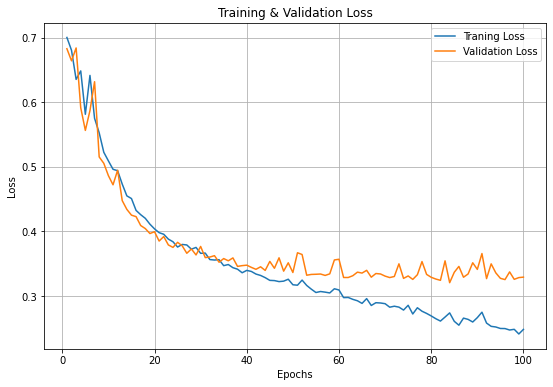

In [ ]:
epochs = range(1, len(hist_imdb.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist_imdb.history['loss'])
plt.plot(epochs, hist_imdb.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Traning Loss', 'Validation Loss'])
plt.grid()
plt.show()

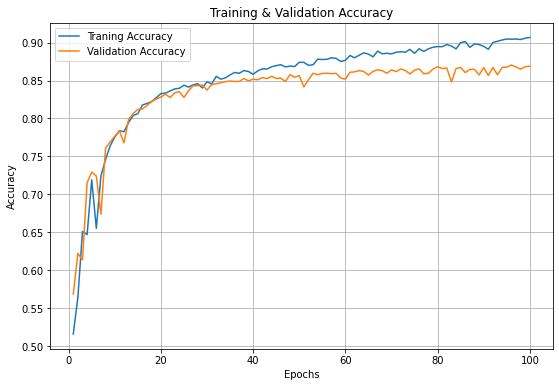

In [ ]:
epochs = range(1, len(hist_imdb.history['accuracy']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist_imdb.history['accuracy'])
plt.plot(epochs, hist_imdb.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Traning Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

### 3) Model Evaluate
- Loss & Accuracy

In [ ]:
loss, accuracy = imdb.evaluate(X_valid, y_valid)

print('Loss = {:.5f}' .format(loss))
print('Accuracy = {:.5f}' .format(accuracy))

313/313 [==============================] - 10s 30ms/step - loss: 0.3291 - accuracy: 0.8688
Loss = 0.32913
Accuracy = 0.86880
